In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.10.0


In [3]:
train_image_path = glob.glob("./dataset/dc/train/*/*.jpg")

In [4]:
len(train_image_path)

2000

In [5]:
train_image_path[-5]

'./dataset/dc/train\\dog\\dog.995.jpg'

In [6]:
p = './dataset/dc/train\\cat\\cat.0.jpg'
p = p.split("\\")
int(p[1]=='cat')

1

In [7]:
# 如果是猫的话，就是1，是狗就是0
train_image_label = [int(path.split("\\")[1]=="cat") for path in train_image_path]

In [8]:
train_image_label[:5]

[1, 1, 1, 1, 1]

In [9]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [10]:
# 读取图片并解码函数
def load_preprosess_image(path, label):
    # 读取图片
    image = tf.io.read_file(path)
    # 解码文件
    image = tf.image.decode_jpeg(image, channels=3)
    # 扭曲图像，使其固定图像大小
    image = tf.image.resize(image,[360,360])
    # 图像增强
    # 随机裁剪
    image = tf.image.random_crop(image, [256,256,3])
    # 左右翻转
    image = tf.image.random_flip_left_right(image)
    # 上下翻转
    image = tf.image.random_flip_up_down(image)
    # 改变亮度
    image = tf.image.random_brightness(image, 0.5)
    # 改变对比度
    image = tf.image.random_contrast(image, 0, 1)
    # 改变图像的数据类型
    image = tf.cast(image, tf.float32)
    # 归一化
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [11]:
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [12]:
# 根据计算机的cpu个数，进行计算
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_image_dataset = train_image_dataset.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [14]:
train_image_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

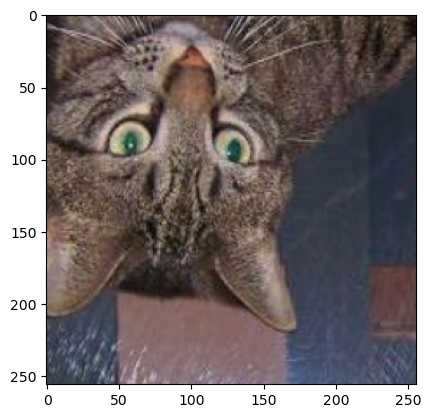

In [15]:
for img, label in train_image_dataset.take(2):
    plt.imshow(img)

In [16]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [17]:
train_image_dataset = train_image_dataset.shuffle(train_count).batch(BATCH_SIZE)
# 加速提取，前面在运行的时候，后台去取图片
train_image_dataset = train_image_dataset.prefetch(AUTOTUNE)

In [18]:
# 读取图片并解码函数
def load_preprosess_image_test(path, label):
    # 读取图片
    image = tf.io.read_file(path)
    # 解码文件
    image = tf.image.decode_jpeg(image, channels=3)
    # 扭曲图像，使其固定图像大小
    image = tf.image.resize(image,[360,360])
    # 改变图像的数据类型
    image = tf.cast(image, tf.float32)
    # 归一化
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [19]:
test_image_path = glob.glob("./dataset/dc/test/*/*.jpg")

In [20]:
test_image_label = [int(path.split("\\")[1]=="cat") for path in test_image_path]

In [21]:
test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))

In [22]:
test_image_dataset = test_image_dataset.map(load_preprosess_image_test, num_parallel_calls=AUTOTUNE)

In [23]:
test_image_dataset = test_image_dataset.batch(BATCH_SIZE)
# 加速提取，前面在运行的时候，后台去取图片
test_image_dataset = test_image_dataset.prefetch(AUTOTUNE)

In [24]:
test_count = len(test_image_path)
test_count

1000

### Keras中内置经典网络实现

In [25]:
covn_base = keras.applications.VGG16(weights="imagenet", include_top=False)

58889256/58889256 [==============================] - 10s 0us/step


In [26]:
covn_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
model = keras.Sequential()
model.add(covn_base)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 设置不可训练
covn_base.trainable=False

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [ ]:
model.fit(
    train_image_dataset,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=15,
    validation_data=test_image_dataset,
    validation_steps=test_count//BATCH_SIZE
)

In [34]:
# 微调
# 1.全部解冻
covn_base.trainable = True

In [35]:
len(covn_base.layers)

19

In [36]:
fine_tune_at = -3

In [37]:
for layer in covn_base.layers[:-3]:
    layer.trainable=False

In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000/10),
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [39]:
initial_epochs = 12
fine_tune_epochs = 10

In [40]:
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:
history = model.fit(
    train_image_dataset,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_dataset,
    validation_steps=test_count//BATCH_SIZE
)